In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator, load_img
from keras.utils.vis_utils import plot_model
from collections import Counter
import datetime
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/"Colab Notebooks"/KaggleLoginCredentials/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d msambare/fer2013

In [ ]:
!unzip '/content/drive/MyDrive/archive.zip'
#!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
 extracting: archive/train/happy/Training_97710835.jpg  
 extracting: archive/train/happy/Training_97742871.jpg  
 extracting: archive/train/happy/Training_97745591.jpg  
 extracting: archive/train/happy/Training_97747826.jpg  
 extracting: archive/train/happy/Training_97775259.jpg  
 extracting: archive/train/happy/Training_97799262.jpg  
 extracting: archive/train/happy/Training_97802283.jpg  
 extracting: archive/train/happy/Training_97806297.jpg  
 extracting: archive/train/happy/Training_97817651.jpg  
 extracting: archive/train/happy/Training_97834497.jpg  
 extracting: archive/train/happy/Training_97858008.jpg  
 extracting: archive/train/happy/Training_9789992.jpg  
 extracting: archive/train/happy/Training_97903432.jpg  
 extracting: archive/train/happy/Training_97907638.jpg  
 extracting: archive/train/happy/Training_97910203.jpg  
 extracting: archive/train/happy/Training_97929683.jpg  
 extracting: archive/train/happy/Train

# New Section

In [ ]:
train_dir = '/content/archive/train/'
test_dir = '/content/archive/test/'
#validation_dir = '/content/fer2013/validation/'

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (48, 48),
                                                 batch_size = 64,
                                                 shuffle=True,
                                                 color_mode='grayscale',
                                                 class_mode = 'categorical')

Found 16040 images belonging to 3 classes.


In [ ]:
# validation_datagen = ImageDataGenerator(rescale = 1./255)
# validation_set = validation_datagen.flow_from_directory(validation_dir,
#                                             target_size = (48, 48),
#                                             batch_size = 64,
#                                             shuffle = True,
#                                             color_mode = 'grayscale',
#                                             class_mode = 'categorical')

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (48, 48),
                                            batch_size = 64,
                                            shuffle = True,
                                            color_mode = 'grayscale',
                                            class_mode = 'categorical')

Found 3979 images belonging to 3 classes.


In [ ]:
training_set.class_indices

{'angry': 0, 'happy': 1, 'sad': 2}

In [ ]:
# validation_set.class_indices

In [ ]:
test_set.class_indices

{'angry': 0, 'happy': 1, 'sad': 2}

In [ ]:
counter = Counter(training_set.classes)
print(counter.items())

dict_items([(0, 3995), (1, 7215), (2, 4830)])


In [ ]:
# counter = Counter(validation_set.classes)
# print(counter.items())

In [ ]:
counter = Counter(test_set.classes)
print(counter.items())

dict_items([(0, 958), (1, 1774), (2, 1247)])


In [ ]:
cnn = tf.keras.models.Sequential()
cnn.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(48, 48, 1)))
cnn.add(BatchNormalization())
cnn.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2), strides=2))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2), strides=2))
cnn.add(Dropout(0.25))
cnn.add(Flatten())
cnn.add(Dense(units=1024, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Dense(units=3, activation='softmax'))

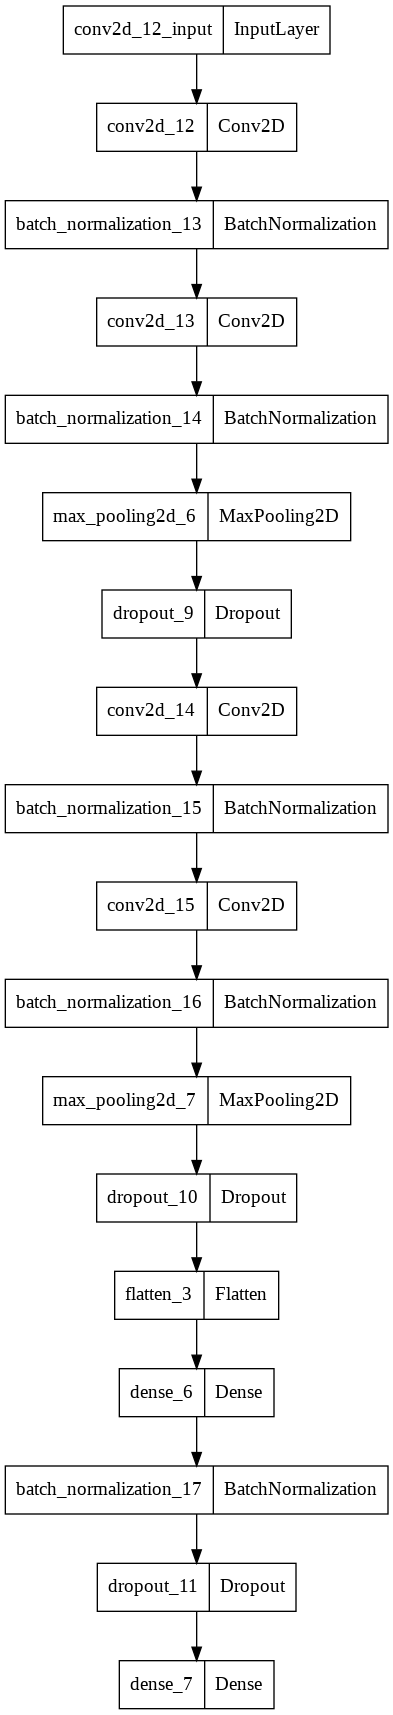

In [ ]:
plot_model(cnn, show_layer_names=True)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# chk_path = '/content/MoodDetector.h5'
# log_dir = "/content/checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# checkpoint = ModelCheckpoint(filepath=chk_path,
#                              save_best_only=True,
#                              verbose=1,
#                              mode='min',
#                              moniter='val_accuracy')

earlystop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=11, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0,
                              min_lr=1e-7)

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# csv_logger = CSVLogger('training.log')

callbacks = [earlystop, reduce_lr] #, csv_logger]

In [ ]:
#steps_per_epoch = training_set.n // training_set.batch_size
#validation_steps = test_set.n // test_set.batch_size

history = cnn.fit(x=training_set,
                  validation_data=test_set,
                  epochs=100,
                  callbacks=callbacks)
#                  steps_per_epoch=training_set.n,
#                  validation_steps=test_set.n)

Epoch 1/100
251/251 [==============================] - 13s 49ms/step - loss: 1.3113 - accuracy: 0.4899 - val_loss: 1.0836 - val_accuracy: 0.4260 - lr: 0.0010
Epoch 2/100
251/251 [==============================] - 12s 48ms/step - loss: 0.9465 - accuracy: 0.5802 - val_loss: 0.8809 - val_accuracy: 0.5614 - lr: 0.0010
Epoch 3/100
251/251 [==============================] - 12s 48ms/step - loss: 0.8117 - accuracy: 0.6300 - val_loss: 0.8351 - val_accuracy: 0.6117 - lr: 0.0010
Epoch 4/100
251/251 [==============================] - 12s 48ms/step - loss: 0.7556 - accuracy: 0.6583 - val_loss: 0.8833 - val_accuracy: 0.5778 - lr: 0.0010
Epoch 5/100
251/251 [==============================] - 12s 49ms/step - loss: 0.6977 - accuracy: 0.6852 - val_loss: 0.7404 - val_accuracy: 0.6755 - lr: 0.0010
Epoch 6/100
251/251 [==============================] - 12s 49ms/step - loss: 0.6584 - accuracy: 0.7062 - val_loss: 0.6662 - val_accuracy: 0.6977 - lr: 0.0010
Epoch 7/100
251/251 [==============================]

In [ ]:
train_loss, train_accu = cnn.evaluate(training_set)
test_loss, test_accu = cnn.evaluate(test_set)
print("final train accuracy = {:.2f}, test accuracy = {:.2f}".format(train_accu*100, test_accu*100))

63/63 [==============================] - 1s 19ms/step - loss: 0.5361 - accuracy: 0.8191
final train accuracy = 97.43, test accuracy = 81.91


In [ ]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 batch_normalization_10 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_11 (Bat  (None, 44, 44, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                      

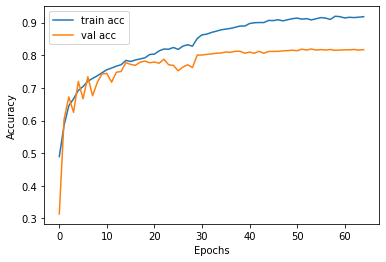

In [ ]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')

plt.plot(history.history['val_accuracy'], label='val acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

#plt.savefig('vgg-acc-rps-1.png')

plt.show()

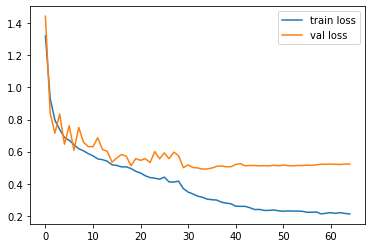

In [ ]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
#plt.savefig('vgg-loss-rps-1.png')
plt.show()

In [ ]:
cnn.save("MoodDetector10.h5")